In [40]:
import mlflow
import mlflow.sklearn

# Tenter de créer/choisir l'expérience sur le serveur de tracking actif.
# En cas d'erreur (ex. 403 sur un serveur distant), on bascule sur un stockage local ('mlruns').
try:
	mlflow.set_experiment("ProjetIA_mlflow")
except mlflow.exceptions.MlflowException as e:
	# Si permission refusée ou autre erreur côté serveur, fallback vers un mlruns local
	err_str = str(e)
	if "403" in err_str or "Permission" in err_str or "Forbidden" in err_str:
		import os
		local_uri = f"file:{os.path.abspath('mlruns')}"
		print(f"Warning: cannot create remote experiment ({e}). Falling back to local tracking URI: {local_uri}")
		mlflow.set_tracking_uri(local_uri)
		mlflow.set_experiment("ProjetIA_mlflow")
	else:
		# pour toute autre erreur, remonter l'exception
		raise

mlflow.autolog()

2025/11/19 16:20:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/19 16:20:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [41]:
import dagshub
dagshub.init(repo_owner='Stephanphanloman', repo_name='ProjectIA_mlflow_dagshub', mlflow=True)

Initialized MLflow to track repo "Stephanphanloman/ProjectIA_mlflow_dagshub"

Repository Stephanphanloman/ProjectIA_mlflow_dagshub initialized!

# Jalon #2 – Optimisation des modèles IA

Description des données

**REGION_ADM_QC_TXT** : Les differentes regions au Quebec

**Date** : Date de la consommation 

**Secteur** : Secteur (Industriel, agricole, commercial, institutionnel, residentiel)

**Consommation_kWh** : La consommation de l'electricite en kilowatt-hour

 # 1. Prétraitement des données

In [42]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('historique-consommation-secteur-activite-ra-mois.csv')

df.head(5)

,REGION_ADM_QC_TXT,ANNEE_MOIS,SECTEUR,Total (kWh)
0,Abitibi-Témiscamingue,2016-01-01,AGRICOLE,3.708809e+06
1,Abitibi-Témiscamingue,2016-02-01,INDUSTRIEL,3.099185e+08
2,Abitibi-Témiscamingue,2016-03-01,AGRICOLE,3.354118e+06
3,Abitibi-Témiscamingue,2016-03-01,INDUSTRIEL,3.118752e+08
4,Abitibi-Témiscamingue,2016-04-01,COMMERCIAL,4.211606e+07


In [43]:
df.describe()

,Total (kWh)
count,7.315000e+03
mean,1.860448e+08
std,2.864466e+08
min,1.041400e+04
25%,2.324878e+07
50%,6.430550e+07
75%,2.221383e+08
max,2.393115e+09


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9180 entries, 0 to 9179
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   REGION_ADM_QC_TXT  9180 non-null   object 
 1   ANNEE_MOIS         9180 non-null   object 
 2   SECTEUR            9180 non-null   object 
 3   Total (kWh)        7315 non-null   float64
dtypes: float64(1), object(3)
memory usage: 287.0+ KB


In [45]:
df["REGION_ADM_QC_TXT"].value_counts()

REGION_ADM_QC_TXT
Abitibi-Témiscamingue             540
Bas-Saint-Laurent                 540
Capitale-Nationale                540
Centre-du-Québec                  540
Chaudière-Appalaches              540
Côte-Nord                         540
Estrie                            540
Gaspésie--Îles-de-la-Madeleine    540
Lanaudière                        540
Laurentides                       540
Laval                             540
Mauricie                          540
Montréal                          540
Montérégie                        540
Nord-du-Québec                    540
Outaouais                         540
Saguenay--Lac-Saint-Jean          540
Name: count, dtype: int64

In [46]:
df["SECTEUR"].value_counts()

SECTEUR
AGRICOLE          1836
INDUSTRIEL        1836
COMMERCIAL        1836
INSTITUTIONNEL    1836
RÉSIDENTIEL       1836
Name: count, dtype: int64

In [47]:
df.isnull().sum()

REGION_ADM_QC_TXT       0
ANNEE_MOIS              0
SECTEUR                 0
Total (kWh)          1865
dtype: int64

In [48]:
# Renommer les colonnes pour faciliter l'utilisation
df.columns = ['Region', 'annee_mois', 'Secteur', 'total_kWh']

In [49]:
# Conversion de la colonne 'annee_mois' en type datetime
df['annee_mois'] = pd.to_datetime(df['annee_mois'])

In [50]:
# Suppression des doublons
df = df.drop_duplicates()

# Supression des valeurs nulles
df = df.dropna(subset=['total_kWh'])

df.head(5)

,Region,annee_mois,Secteur,total_kWh
0,Abitibi-Témiscamingue,2016-01-01,AGRICOLE,3.708809e+06
1,Abitibi-Témiscamingue,2016-02-01,INDUSTRIEL,3.099185e+08
2,Abitibi-Témiscamingue,2016-03-01,AGRICOLE,3.354118e+06
3,Abitibi-Témiscamingue,2016-03-01,INDUSTRIEL,3.118752e+08
4,Abitibi-Témiscamingue,2016-04-01,COMMERCIAL,4.211606e+07


In [51]:
# Variables temporelles
df['annee'] = df['annee_mois'].dt.year
df['mois'] = df['annee_mois'].dt.month  

df = df.sort_values(by='annee_mois')

In [52]:
# Encodage des variables catégorielles
for col in ['Region', 'Secteur']:
    df[col] = LabelEncoder().fit_transform(df[col])

df.head(5)

,Region,annee_mois,Secteur,total_kWh,annee,mois
0,0,2016-01-01,0,3708809.0,2016,1
1363,6,2016-01-01,4,606679291.0,2016,1
8572,12,2016-01-01,1,22696871.0,2016,1
3533,2,2016-01-01,0,26942947.0,2016,1
3534,2,2016-01-01,1,75207054.0,2016,1


In [53]:
# Normalisation des données
scaler = StandardScaler()
df[['total_kWh', 'Region', 'Secteur']] = scaler.fit_transform(df[['total_kWh', 'Region', 'Secteur']])

In [54]:
# Séparation des caractéristiques et de la cible
X = df[['Region', 'Secteur', 'annee', 'mois']]
y = df['total_kWh']

In [55]:
# Séparation des données en ensembles d'entraînement et de test base sur le temps
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 



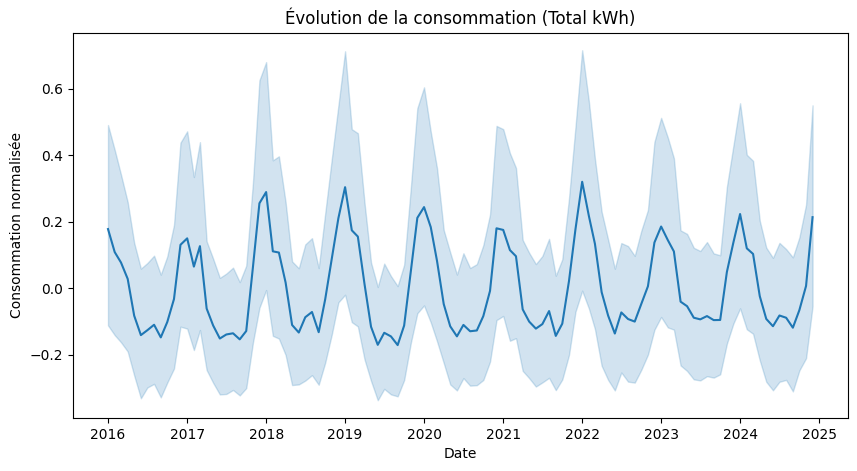

In [56]:
# Visualisation des tendances de consommation par secteur
plt.figure(figsize=(10,5))
sns.lineplot(x="annee_mois", y="total_kWh", data=df)
plt.title("Évolution de la consommation (Total kWh)")
plt.xlabel("Date")
plt.ylabel("Consommation normalisée")
plt.show()

J’ai apporté de nombreuses améliorations au prétraitement de mon jeu de données par rapport au premier jalon. Cette fois, je me suis concentré sur la simplicité et sur l’ajout d’informations pertinentes pour mieux représenter notre sujet, ce qui permet une compréhension plus claire des données relatives à la consommation électrique des clients. Par ailleurs, j’ai veillé à ce que la normalisation et la standardisation des données fonctionnent correctement, ce qui n’était pas le cas lors du précédent jalon. Ces étapes garantissent que les modèles de prédiction puissent traiter les données de manière optimale, réduire les biais liés aux échelles différentes des variables et améliorer la performance globale des prédictions de factures d’électricité.

# 2. Tester et comparer plusieurs modèles

Regression lineaire 

In [57]:
# Creation modele de regression lineaire sans regularisation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Utilisation de la régression linéaire simple
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE (Linear Regression): {mse}")
print(f"R^2 (Linear Regression): {r2}")


2025/11/19 16:20:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '78c7162aa3a148bdb46324712f77c456', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/19 16:20:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Stephan\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

MSE (Linear Regression): 0.8673441762242636
R^2 (Linear Regression): 0.07559874296627755


La régression linéaire a été choisie pour sa simplicité, sa rapidité et sa transparence. Elle permet de comprendre facilement l’impact de chaque variable sur la facture d’électricité et constitue une base de comparaison solide pour évaluer des modèles plus complexes. De plus, elle est particulièrement adaptée à la prédiction de valeurs continues comme le montant des factures.

Foret aleatoire 

In [58]:
# Creation modele random forest avec parametres ajustes
from sklearn.ensemble import RandomForestRegressor

# Ajustement plus strict des hyperparamètres pour réduire le surapprentissage
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,            # Réduit davantage la profondeur des arbres
    min_samples_split=10,   # Augmente le minimum d'échantillons requis pour diviser
    min_samples_leaf=8,     # Augmente le minimum d'échantillons dans les feuilles
    max_features='sqrt',    # Limite le nombre de caractéristiques considérées
    bootstrap=True,         # Active le bootstrap pour plus de régularisation
    random_state=42
)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Affichage des métriques
print(f"MSE (Random Forest): {mse_rf}")
print(f"R^2 (Random Forest): {r2_rf}")


2025/11/19 16:20:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9ba993ca7d4843f59f1d0294362b3ccd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/19 16:20:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Stephan\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

MSE (Random Forest): 0.23485852958245085
R^2 (Random Forest): 0.749691615021608


Le modèle Random Forest a été choisi pour sa capacité à capturer des relations complexes entre les variables et à réduire la variance des prédictions grâce à l’agrégation de plusieurs arbres de décision. Il est robuste face aux valeurs aberrantes et au bruit dans les données, ce qui en fait un excellent choix pour prédire de manière fiable les factures d’électricité.

XGBoost 

In [59]:
# Creation modele XGBoost avec parametres ajustes
from xgboost import XGBRegressor

# Ajustement des hyperparamètres pour réduire le surapprentissage
model_xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,     # Réduit pour un apprentissage plus lent
    max_depth=4,           # Réduit la profondeur maximum
    min_child_weight=3,    # Augmente pour réduire le surapprentissage
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,         # Régularisation L1
    reg_lambda=1.0,        # Régularisation L2
    random_state=42
)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"MSE (XGBoost): {mse_xgb}")
print(f"R^2 (XGBoost): {r2_xgb}")

2025/11/19 16:20:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad5cd76c412f4bc5bed0efdda83c2ebb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/11/19 16:20:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Stephan\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

MSE (XGBoost): 0.16462553309187777
R^2 (XGBoost): 0.8245447955937732


XGBoost a été choisi pour sa puissance à modéliser des relations non linéaires complexes et à optimiser la performance grâce à un apprentissage par gradient. Il combine précision et robustesse, tout en gérant efficacement le surapprentissage, ce qui le rend particulièrement adapté à la prédiction précise des factures d’électricité.

# 3. Évaluer la performance de vos modèles

In [60]:
# Metriques de performance des modèles
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Affichage des métriques Linear Regression
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE (Linear Regression): {mse}")
print(f"R^2 (Linear Regression): {r2}")
print(f"MAE (Linear Regression): {mae}")
print(f"RMSE (Linear Regression): {rmse}")

# Affichage des métriques Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf) 
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"\nMSE (Random Forest): {mse_rf}")
print(f"R^2 (Random Forest): {r2_rf}")
print(f"MAE (Random Forest): {mae_rf}")
print(f"RMSE (Random Forest): {rmse_rf}")

# Affichage des métriques XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"\nMSE (XGBoost): {mse_xgb}")
print(f"R^2 (XGBoost): {r2_xgb}")
print(f"MAE (XGBoost): {mae_xgb}")
print(f"RMSE (XGBoost): {rmse_xgb}")



MSE (Linear Regression): 0.8673441762242636
R^2 (Linear Regression): 0.07559874296627755
MAE (Linear Regression): 0.62259712529761
RMSE (Linear Regression): 0.9313131461674229

MSE (Random Forest): 0.23485852958245085
R^2 (Random Forest): 0.749691615021608
MAE (Random Forest): 0.30967193485080485
RMSE (Random Forest): 0.48462204818028126

MSE (XGBoost): 0.16462553309187777
R^2 (XGBoost): 0.8245447955937732
MAE (XGBoost): 0.2661075198777781
RMSE (XGBoost): 0.40574072151052054


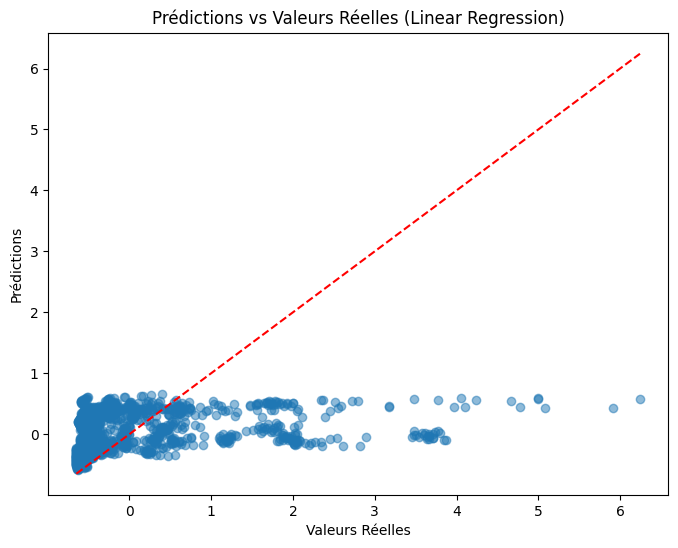

In [61]:
# Scatter plot des prédictions vs valeurs réelles pour le modèle Linear Regression
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Prédictions vs Valeurs Réelles (Linear Regression)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.show()



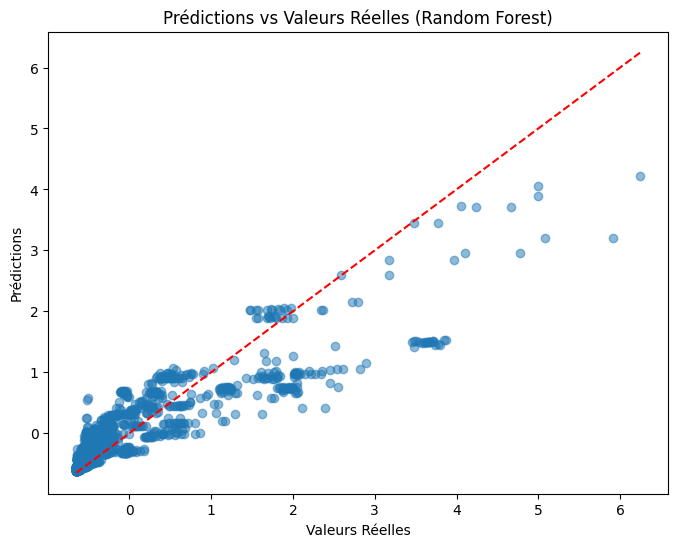

In [62]:
# scatter plot des prédictions vs valeurs réelles pour le modèle Random Forest
scatter_rf = plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.title("Prédictions vs Valeurs Réelles (Random Forest)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

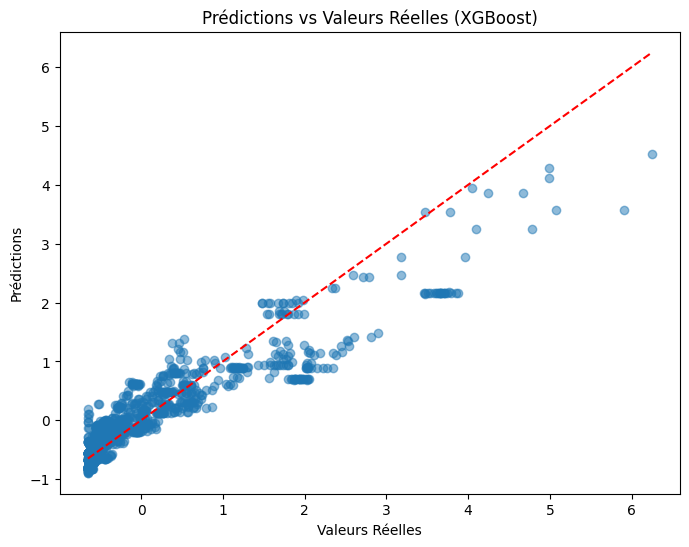

In [63]:
# Scatter plot des prédictions vs valeurs réelles pour le modèle XGBoost
scatter_Xgboost = plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.title("Prédictions vs Valeurs Réelles (XGBoost)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

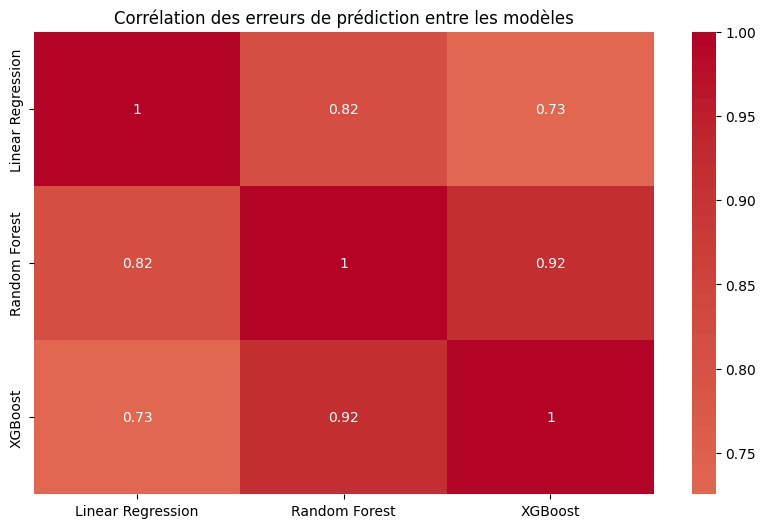

In [64]:
# Heatmap des erreurs de prédiction pour les trois modèles
errors = pd.DataFrame({
    'Linear Regression': y_test - y_pred,
    'Random Forest': y_test - y_pred_rf,
    'XGBoost': y_test - y_pred_xgb
})

plt.figure(figsize=(10,6))
sns.heatmap(errors.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation des erreurs de prédiction entre les modèles")
plt.show()

C:\Users\Stephan\AppData\Local\Temp\ipykernel_27192\1487953581.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, palette='viridis')


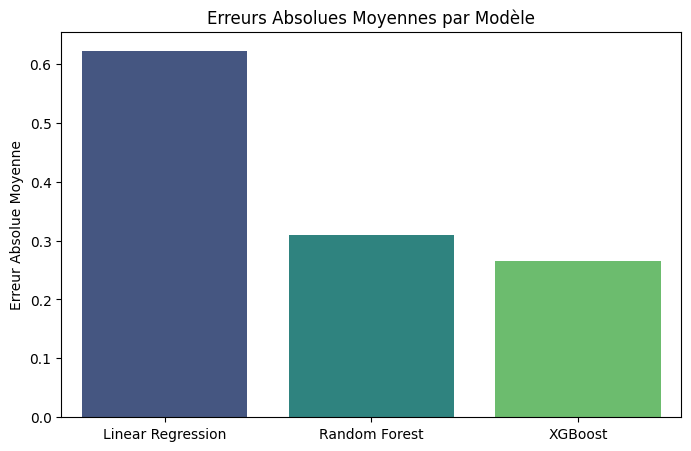

In [65]:
# Bar chart des erreurs absolues moyennes pour les trois modèles
mae_values = [mae, mae_rf, mae_xgb]
models = ['Linear Regression', 'Random Forest', 'XGBoost']
plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_values, palette='viridis')
plt.title("Erreurs Absolues Moyennes par Modèle")
plt.ylabel("Erreur Absolue Moyenne")
plt.show()

Une visualisation rapide de la moyenne de l’erreur absolue pour les trois modèles montre que la régression linéaire présente une valeur plus élevée que les deux autres. Cela indique une certaine instabilité face à la cohérence du jeu de données. De plus, l’analyse du graphique Scatter Plot révèle que la régression linéaire s’écarte davantage de la ligne de tendance, contrairement aux autres modèles qui semblent mieux s’adapter et capturer les relations présentes dans les données. Bien qu’aucun modèle ne soit parfaitement aligné, il est probable que les deux autres puissent donner de meilleurs résultats avec un ajustement et une optimisation appropriés.

# 4. Optimisation d'un ou deux modèle(s)

In [66]:
# Optimisation de Random Forest avec RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
y_pred_optimized_rf = best_rf.predict(X_test)
mse_optimized_rf = mean_squared_error(y_test, y_pred_optimized_rf)
r2_optimized_rf = r2_score(y_test, y_pred_optimized_rf)
print(f"Optimized Random Forest MSE: {mse_optimized_rf}")
print(f"Optimized Random Forest R^2: {r2_optimized_rf}")


2025/11/19 16:20:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2f9cd6fb1ac44130ae0d964782d05553', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/19 16:20:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Stephan\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

Optimized Random Forest MSE: 0.0629807509837135
Optimized Random Forest R^2: 0.9328761442410156


In [67]:
# Optimation de XGBoost avec RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist_xgb = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}
xgb = XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42)
random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
y_pred_optimized_xgb = best_xgb.predict(X_test)
mse_optimized_xgb = mean_squared_error(y_test, y_pred_optimized_xgb)
r2_optimized_xgb = r2_score(y_test, y_pred_optimized_xgb)
print(f"Optimized XGBoost MSE: {mse_optimized_xgb}")
print(f"Optimized XGBoost R^2: {r2_optimized_xgb}")


2025/11/19 16:21:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '853aebf490964f2eb7adc1e5d1e2cef5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/11/19 16:21:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Stephan\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling In

Optimized XGBoost MSE: 0.010757787204207349
Optimized XGBoost R^2: 0.9885345261003986


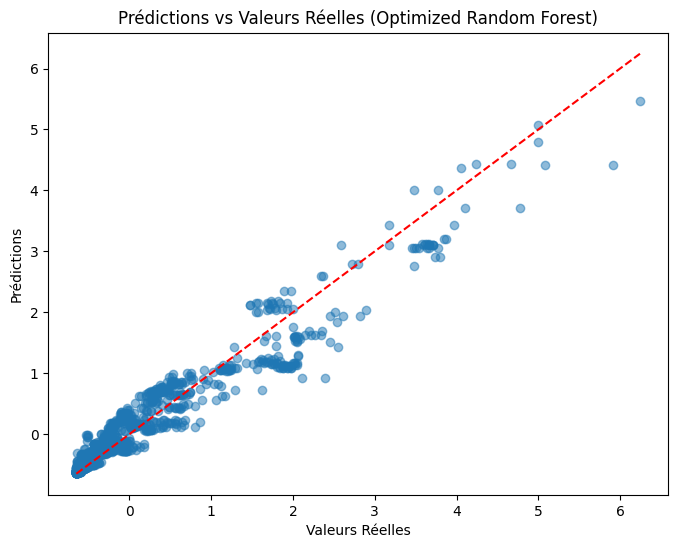

In [68]:
# scatter plot des prédictions vs valeurs réelles pour le modèle Random Forest optimisé
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_optimized_rf, alpha=0.5)
plt.title("Prédictions vs Valeurs Réelles (Optimized Random Forest)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


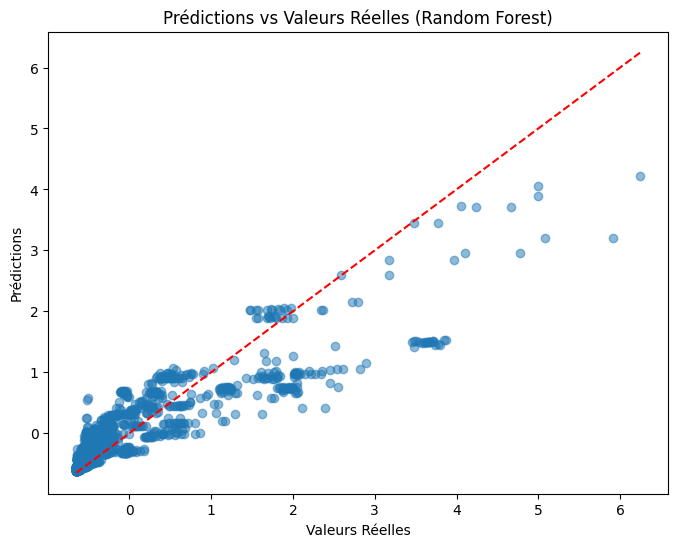

In [69]:
scatter_rf

Ici, on observe qu’en optimisant le modèle Random Forest, l’alignement des données sur la ligne de tendance linéaire s’améliore. Cette amélioration reste modérée, probablement parce que le modèle entraîne plusieurs arbres indépendants, chacun sur un échantillon aléatoire des données. La prédiction finale correspond à la moyenne des prédictions de tous les arbres, ce qui conduit à une réduction de la variance et à des prédictions plus stables, tout en limitant l’impact des anomalies ou du bruit dans les données.

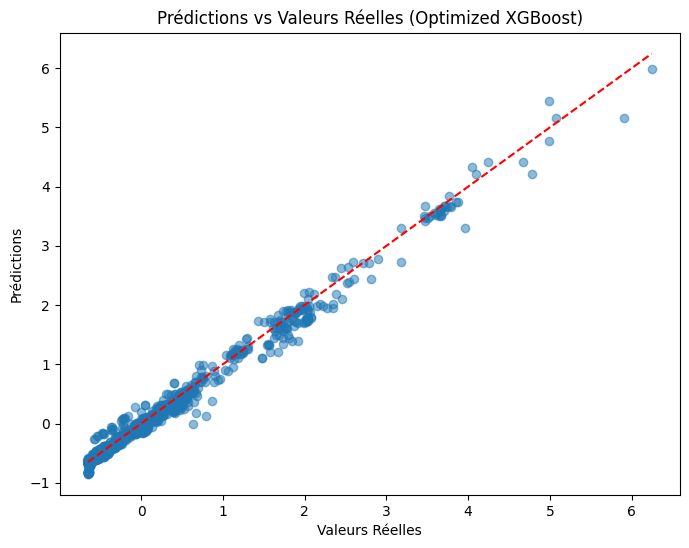

In [70]:
# Scatter plot des prédictions vs valeurs réelles pour XGBoost optimisé
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_optimized_xgb, alpha=0.5)
plt.title("Prédictions vs Valeurs Réelles (Optimized XGBoost)")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

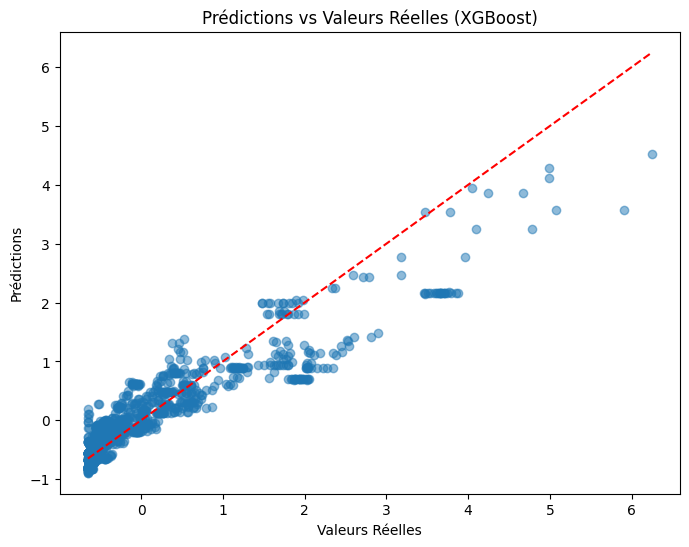

In [71]:
scatter_Xgboost

D’après la visualisation graphique comparant les valeurs réelles aux prédictions du modèle XGBoost, on observe une nette amélioration après l’optimisation. Les points de données s’alignent plus étroitement sur la ligne de tendance linéaire, et la dispersion autour de celle-ci est réduite par rapport au modèle précédent. Cela indique que le modèle optimisé génère des prédictions plus précises et parvient à mieux capturer la relation entre les variables d’entrée et la variable cible.

# 5. Sélectionner un modèle final

In [72]:
# Validation croise avex XGBoost optimise
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_xgb, X, y, cv=5, scoring='r2')
print("R2 moyen :", np.mean(scores))
print("Ecart-type :", np.std(scores))

R2 moyen : 0.9820859290674828
Ecart-type : 0.006098452833729357


In [73]:
# Comparaison des performances des donnees train et test 
from sklearn.metrics import r2_score, mean_squared_error

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("R2 (train):", r2_train)
print("R2 (test):", r2_test)
print("MSE (train):", mse_train)
print("MSE (test):", mse_test)

R2 (train): 0.9972532594003567
R2 (test): 0.9885345261003986
MSE (train): 0.0027890794062457483
MSE (test): 0.010757787204207349


In [74]:
# Sauvegarder le modèle XGBoost optimisé (best_xgb)
import joblib
import os

save_dir = '.'

# Sauvegarde avec joblib (pickle)
pkl_path = os.path.join(save_dir, 'best_xgb.pkl')
try:
    joblib.dump(best_xgb, pkl_path)
    print(f"Modèle sauvegardé (joblib) -> {pkl_path}")
except Exception as e:
    print('Erreur sauvegarde joblib:', e)

# Sauvegarde avec la méthode native XGBoost (JSON)
json_path = os.path.join(save_dir, 'best_xgb.json')
try:
    best_xgb.save_model(json_path)
    print(f"Modèle sauvegardé (XGBoost) -> {json_path}")
except Exception as e:
    print('Erreur sauvegarde XGBoost save_model:', e)

# Test rapide : recharger le modèle joblib et prédire quelques échantillons
try:
    mdl = joblib.load(pkl_path)
    preds = mdl.predict(X_test.iloc[:5])
    print('Prédictions échantillon (rechargé joblib):', preds)
except Exception as e:
    print('Erreur lors du rechargement/prédiction (joblib):', e)

print('\nPour recharger plus tard :')
print("import joblib\nmodel = joblib.load('best_xgb.pkl')")
print("# ou (XGBoost natif) :\nfrom xgboost import XGBRegressor\nm = XGBRegressor(); m.load_model('best_xgb.json')")

Modèle sauvegardé (joblib) -> .\best_xgb.pkl
Modèle sauvegardé (XGBoost) -> .\best_xgb.json
Prédictions échantillon (rechargé joblib): [-0.20922604 -0.50574344 -0.5999617  -0.4100934   1.911967  ]

Pour recharger plus tard :
import joblib
model = joblib.load('best_xgb.pkl')
# ou (XGBoost natif) :
from xgboost import XGBRegressor
m = XGBRegressor(); m.load_model('best_xgb.json')


Le modèle que j'ai décidé de choisir est le XGBoost optimisé. D'après les comparaisons des performances sur les données Train/Test et les visualisations graphiques de leurs valeurs réelles/prédictions, elle présente des résultats performants, une stabilité élevée et une bonne capacité d'interprétation.

Sur le plan de performance, le modèle présente un R2 de 0.9885 et un MSE de 0.0107 ce qui indique une très forte capacité à expliquer la variance de la variable cible tout en maintenant un niveau d’erreur faible. De plus, la validation croisée confirme la robustesse du modèle avec un R² moyen élevé et un écart-type de 0.0061. Les résultats démontrent qu’ils demeurent cohérents sur différents sous-échantillons des données.

Pour ce qui est de la stabilité, la comparaison des performances entre l’ensemble d’entraînement et l’ensemble de test ne montre aucun signe de surapprentissage. On confirme donc une bonne généralisation du modèle.

Pour l’interprétabilité du modèle XGBoost, il renforce l’analyse de l’importance des variables et les contributions de chaque caractéristique avec les outils tels que SHAP ou la feature importance. Ils permettent de mieux comprendre les facteurs qui influencent les prédictions.



In [ ]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'Stephanphanloman'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'ba530ff72c250bddf9385ead51ca25be2e114261'
# mlflow.set_tracking_uri("http://127.0.0.1:5000")

try:
    mlflow.set_tracking_uri("https://dagshub.com/Stephanphanloman/ProjectIA_mlflow_dagshub.mlflow")
    with mlflow.start_run():
        mlflow.log_params({
            'n_estimators': best_xgb.n_estimators,
            'max_depth': best_xgb.max_depth,
            'learning_rate': best_xgb.learning_rate
        })
        mlflow.log_metrics({
            'r2_score': r2_test,
            'mse': mse_test,
            'mae': mean_absolute_error(y_test, y_pred_test)
        })
        mlflow.sklearn.log_model(best_xgb, 'best_xgb_model')
        print("Model logged successfully to DagsHub")
except Exception as e:
    print(f"Failed to log to DagsHub ({e}). Falling back to local MLflow storage...")
    mlflow.set_tracking_uri("file:./mlruns")
    mlflow.set_experiment("ProjetIA_mlflow")
    with mlflow.start_run():
        mlflow.log_params({
            'n_estimators': best_xgb.n_estimators,
            'max_depth': best_xgb.max_depth,
            'learning_rate': best_xgb.learning_rate
        })
        mlflow.log_metrics({
            'r2_score': r2_test,
            'mse': mse_test,
            'mae': mean_absolute_error(y_test, y_pred_test)
        })
        mlflow.sklearn.log_model(best_xgb, 'best_xgb_model')
        print("Model logged successfully to local MLflow storage")


    

2025/11/19 16:36:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Failed to log to DagsHub (API request to https://dagshub.com/Stephanphanloman/ProjectIA_mlflow_dagshub.mlflow/api/2.0/mlflow/runs/create failed with exception HTTPSConnectionPool(host='dagshub.com', port=443): Max retries exceeded with url: /Stephanphanloman/ProjectIA_mlflow_dagshub.mlflow/api/2.0/mlflow/runs/create (Caused by ResponseError('too many 500 error responses'))). Falling back to local MLflow storage...


2025/11/19 16:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully to local MLflow storage
